In [ ]:
#|default_exp reader

# Parsing our first pdz file 

> Let's bite off some bytes... 

Bruker `.pdz` files are binary files that contain both spectral data (i.e. counts) and metadata. There is no official description of the file format, so in order to decode the bytes we need to do some reverse engineering. To get an idea how a pdz file is structured we first need to read the file into memory as an array of bytes using the `file_to_bytes()` and `get_blocks()` functions.  

In [ ]:
from read_pdz import file_to_bytes, get_blocks

In [ ]:
pdz_file = '../downloads/s0243V1962_XRF_28_White edge clothes underpainting (Al 38um filter).pdz'

pdz_bytes = file_to_bytes(pdz_file)
block_list = get_blocks(pdz_bytes)

Detecting block sequence...
Ok!


To our understanding pdz files consist of a sequence of blocks that contain different types of information. Let's take a look at our `block_list` variable. 

In [ ]:
block_list

[{'block_type': 25,
  'size': 14,
  'start': 0,
  'stop': 20,
  'file_size': 8690,
  'bytes': array([b'p', b'', b'd', b'', b'z', b'', b'2', b'', b'5', b'', b'\x01',
         b'', b'', b''], dtype='|S1')},
 {'block_type': 1,
  'size': 228,
  'start': 20,
  'stop': 254,
  'file_size': 8690,
  'bytes': array([b'\x08', b'', b'', b'', b'9', b'', b'0', b'', b'0', b'', b'F', b'',
         b'4', b'', b'9', b'', b'6', b'', b'9', b'', b'\x08', b'', b'', b'',
         b'S', b'', b'K', b'', b'5', b'', b'-', b'', b'4', b'', b'9', b'',
         b'6', b'', b'9', b'', b'-', b'-', b'-', b'A', b'}', b'', b'\x06',
         b'', b'', b'', b'A', b'', b'm', b'', b'p', b'', b't', b'', b'e',
         b'', b'k', b'', b'\x04', b'', b'', b'', b'R', b'', b'x', b'', b'B',
         b'', b'x', b'', b'\x03', b'\x08', b'\x07', b'', b'', b'', b'M',
         b'', b'o', b'', b'v', b'', b'a', b'', b'b', b'', b'l', b'', b'e',
         b'', b'\x08', b'', b'', b'', b'\x01', b'', b'\t', b'', b'', b'',
         b'8', b'', b'.'

The example pdz file here contains exactly four consecutive blocks of bytes. Within each block the first two bytes of contain a (short) integer value that indicates the type of block, while the second four bytes contain an integer value that describes the length of that block. The first two bytes of the first block contain an integer value '25'. This indicates that the pdz format is 25. The next blocks are type 1, 2 and 3. Block types 1 and 2 contain various instrument metadata, while block type 3 contains the actual spectral data. According to our local XRF guru Luc Megens a pdz file can contain multiple XRF spectra in separate type 3 blocks. Furthermore pdz files can contain type 4, 5 and 6 blocks. For now we will ignore these. 

To simply extract the spectral data from a pdz file use the `extract_spectra()` function. This function automatically saves the spectral data to a .csv file and returns a pandas DataFrame. With the `.plot()` method we can directly create a figure to inspect the spectrum. 

In [ ]:
from read_pdz import extract_spectra

In [ ]:
spectra_df = extract_spectra(pdz_file)

<Axes: >

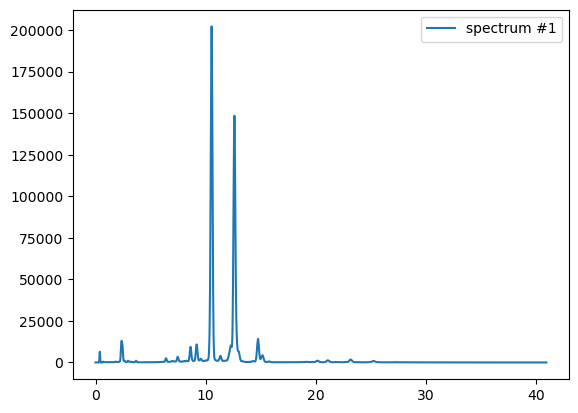

In [ ]:
spectra_df.plot()

In [ ]:
#|hide  

def parse_block_type3(values): 
    '''Type 3 block contains all spectral parameters and count data. '''

    # split into parameters and counts 
    # (assuming that we have 2048 channels)  
    n_channels = 2048 
    param_values = values[0:-n_channels*4]
    count_values = values[-n_channels*4:]

    # process spectrum parameters 
    
    param_nums, param_values = unpack('<iiifffffffffhhhhhhhfhfhfhfhhhhhhhhfhi', param_values) # numerical stuff  
    param_string, param_values = extract_strings(1, param_values) # plus a string 
    a_short, param_values = unpack('<h', param_values) # plus a short 

    params = list(param_nums) + param_string + list(a_short)

    param_keys = ['Unknown_1', 'RawCounts', 'ValidCounts', 'Unknown_2', 'Unknown_3', 'Unknown_4',
                  'ActiveTimeInSeconds', 'DeadTimeInSeconds', 'ResetTimeInSeconds', 'LiveTimeInSeconds', 
                  'XrayVoltageInkV', 'XrayFilamentCurrentInMicroAmps', 'Filter1ElementAtomicNum', 'Filter1Thickness', 
                  'Filter2ElementAtomicNum', 'Filter2Thickness', 'Filter3ElementAtomicNum', 'Filter3Thickness', 
                  'Unknown_5', 'DetectorTempInC', 'Unknown_6', 'Unknown_7', 'Unknown_8', 'eVPerChannel', 
                  'Unknown_6', 'StartingKeV(x1000)', 'Year', 'Month', 'AM/PM code?', 'Day', 'Hour', 'Minutes', 
                  'Seconds', 'Unknown_9', 'NosePressureInMilliBars', 'NumberOfChannels', 'NoseTemperatureInC', 
                   'TubeSpec', 'Unknown_10'] 

    params_dict = dict(zip(param_keys, params))

    # process the actual spectral data 
    # these are stored as 2048 integers 

    counts_list = [c[0] for c in struct.iter_unpack('<i', count_values)] # integers
    counts = np.array(counts_list)
    
    return params_dict, counts
    

In [ ]:
#|hide 
    [3] TubeTargetElement,45
    [4] NumberOfSpectra,1
    [5] SampleID,
    [6] AcquisitionDateTime,8/23/2022 11:54:32 AM
    [7] TotalElapsedTimeInSeconds,112.7783
    [8] AnodeTakeOffAngle,45
    [9] SampleIncidenceAngle,45
    [10] BeThicknessInMicroMeters,125
    [11] SampleTakeOffAngle,65
    [12] XrayVoltageInkV,40,
    [13] XrayFilamentCurrentInMicroAmps,8,
    [14] RawCounts,8139946,
    [15] ValidCounts,4976150,
    [16] eVPerChannel,20,
    [17] StartingKeV,0.002356571,
    [18] ZeroOffsetInKeV,-0.002356571,
    [19] StartingChannel,0.1178286,
    [20] NumberOfChannels,2048,
    [21] CountsPerSecond,147230.7,
    [22] XilinxFirmwareVersion,,
    [23] Filter1ElementAtomicNum,13,
    [24] Filter1Thickness,38,
    [25] Filter2ElementAtomicNum,0,
    [26] Filter2Thickness,0,
    [27] Filter3ElementAtomicNum,0,
    [28] Filter3Thickness,0,
    [29] AcquisitionDateTime,8/23/2022 11:54:32 AM,
    [30] LiveTimeInSeconds,24.532,
    [31] DeadTimeInSeconds,16.83,
    [32] ResetTimeInSeconds,13.92501,
    [33] DetectorTempInC,37.5,
    [34] AmbientTempInF,0,
    [35] NosePressureInMilliBars,1017,
    [36] NoseTemperatureInC,38,
    [37] ActiveTimeInSeconds,55.287,
    [38] PacketTimeInSeconds,69.21201,
    [39] CommunicationTimeInSeconds,,
    [40] ElapsedClockTimeInSeconds,112.7783,
    [41] Spectrum:ChannelNumber,ChannelStartInKeV,ChannelCount

In [ ]:
#|hide 
params_dict, counts = parse_block_type3(values)
params_dict, counts

({'Unknown_1': 0,
  'RawCounts': 8139946,
  'ValidCounts': 4976150,
  'Unknown_2': 0.0,
  'Unknown_3': 0.0,
  'Unknown_4': 55.394989013671875,
  'ActiveTimeInSeconds': 55.28700256347656,
  'DeadTimeInSeconds': 16.830001831054688,
  'ResetTimeInSeconds': 13.925005912780762,
  'LiveTimeInSeconds': 24.532001495361328,
  'XrayVoltageInkV': 40.0,
  'XrayFilamentCurrentInMicroAmps': 8.0,
  'Filter1ElementAtomicNum': 13,
  'Filter1Thickness': 38,
  'Filter2ElementAtomicNum': 0,
  'Filter2Thickness': 0,
  'Filter3ElementAtomicNum': 0,
  'Filter3Thickness': 0,
  'Unknown_5': 5,
  'DetectorTempInC': 37.5,
  'Unknown_6': 2,
  'Unknown_7': 0.0,
  'Unknown_8': 0,
  'eVPerChannel': 20.0,
  'StartingKeV(x1000)': 2.3565714359283447,
  'Year': 2022,
  'Month': 8,
  'AM/PM code?': 2,
  'Day': 23,
  'Hour': 11,
  'Minutes': 54,
  'Seconds': 32,
  'Unknown_9': 320,
  'NosePressureInMilliBars': 1017.0,
  'NumberOfChannels': 2048,
  'NoseTemperatureInC': 38,
  'TubeSpec': 'RoHS 50 Hi-Z',
  'Unknown_10': 1},

In [ ]:
#|hide 
spectrum_parameters unpack('<iiifffffffffhhhhhhhfhfhfhfhhhhhhhhfhi', param_values)


((0,
  8139946,
  4976150,
  0.0,
  0.0,
  55.394989013671875,
  55.28700256347656,
  16.830001831054688,
  13.925005912780762,
  24.532001495361328,
  40.0,
  8.0,
  13,
  38,
  0,
  0,
  0,
  0,
  5,
  37.5,
  0,
  0.0,
  0,
  20.0,
  2,
  2.3565714359283447,
  2022,
  8,
  2,
  23,
  11,
  54,
  32,
  320,
  1017.0,
  2048,
  38),
 array([b'\x0c', b'', b'', b'', b'R', b'', b'o', b'', b'H', b'', b'S', b'',
        b' ', b'', b'5', b'', b'0', b'', b' ', b'', b'H', b'', b'i', b'',
        b'-', b'', b'Z', b'', b'\x01', b''], dtype='|S1'))

In [ ]:
#|hide
b0 = block_list[0]['bytes']
multiparse('10X-i', b0)

[b'pdz25', 1]


([b'pdz25', 1], array([], dtype='|S1'))

In [ ]:
#|hide
b1 = block_list[1]['bytes']

In [ ]:
#|hide 
parsed, arr = multiparse('2S-6X-2S-h-S-T', b1, verbose=False)
parsed, arr

(['900F4969',
  'SK5-4969',
  b'---A}',
  'Amptek',
  'RxBx',
  2051,
  'Movable',
  [['#1', '8.0.0.446'],
   ['#2', '200.39'],
   ['#3', '6.03'],
   ['#4', '3.03'],
   ['#5', '9.2F'],
   ['#6', '200.39'],
   ['#7', '1.11'],
   ['#8', '1.01']]],
 array([], dtype='|S1'))

In [ ]:
#|hide
b3 = block_list[3]['bytes']

In [ ]:
#|export 
import struct 
import numpy as np 
import os 
import re
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
#|export 

def extract_spectra(pdz_file, to_csv=True, verbose=True): 
    '''Directly extract spectral data from `pdz_file`. 
    
    Robust extraction of spectrum counts and energy calibration. Other meta data is ignored. '''

    pdz_bytes = file_to_bytes(pdz_file)
    block_list = get_blocks(pdz_bytes, verbose=False) 
    
    # select type 3 blocks
    b3_list = [b for b in block_list if b['block_type'] == 3] 
    n_spectra = len(b3_list) 

    # parsing spectrum parameters 
    #from first block to compute channel energies (keV) 
    # (assuming that these are similar for all spectra in the pdz file) 
    
    arr = b3_list[0]['bytes'] # only using first block!  
    spectrum_params = multiparse('3i9f7hfhfhfhf8hfhi-S-h', arr, verbose=False)[0]  
    tube_keV = spectrum_params[10] # FYI 
    delta_keV = spectrum_params[23] / 1000
    start_keV = -spectrum_params[25] / 1000 
    n_channels = spectrum_params[35] 
    if n_channels != 2048: 
        print(f'Found unexpected number of channels in pdz metadata: {n_channels}')
        
    stop_keV = start_keV + delta_keV * (n_channels -1)
    x_keV = np.linspace(start_keV, stop_keV, num=n_channels) 

    # initialize array 
    
    spectra_df = pd.DataFrame(index=x_keV)

    # TODO: Test if computed channel energies `x_keV` are reasonable, 
    # Parsing of spectrum parameters might fail 
    # if Bruker messes with file format.   
    # otherwise fall back on 0-40 keV range  

    spectrum_list = [] 

    for i, b3 in enumerate(b3_list):  
        arr = b3['bytes'] 
        counts = np.array(parse(f'{n_channels}i', arr[-4*n_channels:], verbose=False)[0])  

        spectra_df[f'spectrum #{i+1}'] = counts

    if to_csv == True: 
        spectra_df.to_csv(f'{pdz_file}.spectral_data.csv', float_format='%10.5f')

    return spectra_df
           

def multiparse(xformat, arr, verbose=True): 
    '''Parse segments in extendend format string `xformat` e.g. '<i5f-2S-T-3S-S-f' '''

    
    parts = re.split('-', xformat) 

    result_list = []
    for p in parts: 
        if 'S' in p:
            result, arr = read_strings(p, arr, verbose=False) 
        elif p == 'T': 
            result, arr = read_table(p, arr, verbose=False) 
        elif 'X' in p: 
            result, arr = skip_bytes(p, arr, verbose=False) 
        else: 
            result, arr = parse(p, arr, verbose=False) 
            
        result_list.extend(result)   

    if verbose: 
        print(result_list)

    return result_list, arr   

def prefix(format): 
    '''Prefix little endian byte order (<) to struct type format string if missing. '''

    if not format.startswith('<'): 
        format = f'<{format}'
    
    return format    

def file_to_bytes(pdz_file): 
    '''Read all bytes from filepath `pdz_file` into a byte array. 
    
    Returns: `pdz_arr` (numpy array of bytes)
    '''

    with open(pdz_file, 'rb') as fh: 
        blob = fh.read() 
        
    pdz_arr = np.array([v[0] for v in struct.iter_unpack('c', blob)])
    #pdz_arr = bytearray(blob)

    return pdz_arr 
    

def parse(format, arr, verbose=True): 
    '''Parse first bytes from bytes array `arr` into human readable text according to `format` string. 
    
    See struct library for format string specification. For example, '<ff' would result 
    the first 8 bytes to be converted into two Little-Endian floats. 
    
    Returns: `parsed` list and remaining bytes array of `tail_arr` unprocessed `values`.'''

    format = prefix(format) 
    size = struct.calcsize(format)
    buffer = arr[0:size]
    tail_arr = arr[size:]

    parsed = list(struct.unpack(format, buffer)) 

    if verbose: 
        print(parsed)
    
    return parsed, tail_arr

def read_strings(xformat, arr, verbose=True): 
    '''Parse `n` variable length character strings preceded by a length integer. 
     
    '''
    # get multiplier  
    if xformat == 'S': 
        n = 1
    else: 
        n = int(re.sub('(^\d+)S', '\g<1>', xformat))

    # parse strings 
    string_list = [] 
    while n > 0: 
        [length], arr = parse('<i', arr, verbose=False) # read length 
        n_bytes = 2 * length 

        # do some testing 
        assert (n_bytes > 1) and (type(n_bytes) is int), f'{n_bytes} is invalid string length' 
        
        char_list, arr = parse(f'<{n_bytes}c', arr, verbose=False) 
        string = b''.join(char_list).decode(encoding='utf-16') 
        string_list.append(string) 
        n = n -1 
        
    if verbose: 
        print(string_list) 

    return string_list, arr


def skip_bytes(xformat, arr, verbose=True): 
    '''Skip `n_bytes`'''

    # get multiplier  
    if xformat == 'X': 
        n_bytes = 1
    else: 
        n_bytes = int(re.sub('(^\d+)X', '\g<1>', xformat))

    skipped = [b''.join(arr[0:n_bytes])] 

    arr = arr[n_bytes:] 

    if verbose: 
        print(skipped)

    return skipped, arr 
    

def read_table(xformat, arr, verbose=True): 
    '''Extract numbered table'''

    assert xformat == 'T', 'Incorrect format string'

    [table_length], arr = parse('<i', arr, verbose=False) 

    table = []
    for i in range(table_length): 
        [num], arr = parse('<h', arr, verbose=False)  
        [string], arr = read_strings('S', arr, verbose=False)
        table.append([f'#{num}', string]) 
        
    if verbose: 
        print(table)

    return [table], arr
    

def get_block_at(pdz_arr, start): 
    '''Read first data block from bytes array `pdz_arr` from index position `start`. 

    Assumes that first 4 bytes are (block type and size)
    
    Returns: `block_dict`, `block` 
    '''

    file_size = len(pdz_arr)
    
    [block_type, block_size], arr = parse('<hi', pdz_arr[start:], verbose=False)
    
    block_type = struct.unpack('<h', pdz_arr[start:start+2])[0] 
    size = struct.unpack('<i', pdz_arr[start+2:start+6])[0] 
    stop = start + size + 6 # four bytes extra due to `dtype` and `size` shorts plus two empty pad bytes? 

    # read block bytes
    arr = pdz_arr[start+6:stop] 
    
    block_dict = {'block_type': block_type, 'size': size, 'start': start, 'stop': stop, 
                  'file_size': file_size, 'bytes': arr}

    return block_dict


def get_blocks(pdz_bytes, verbose=True): 
    '''Parse `pdz_byte_array` into consequtive blocks. ''' 

    if verbose: 
        print('Detecting block sequence...')
    
    start = 0 
    total_size = len(pdz_bytes) 

    block_list = [] 
    while start < total_size: 
        block_dict = get_block_at(pdz_bytes, start)
        start = block_dict['stop']
        block_list.append(block_dict)

    else:
        if start == total_size: 
            if verbose: 
                print('Ok!')
        else: 
            print('Error while reading last block! ')
            print(f'Stop index: {start} does not match total file size: {total_size}')
        
    return block_list
       

In [ ]:
#|hide 
def 
    # split into parameters and counts 
    # (assuming that we have 2048 channels)  
    n_channels = 2048 
    param_values = values[0:-n_channels*4]
    count_values = values[-n_channels*4:]

    # process spectrum parameters 
    
    param_nums, param_values = unpack_head('<iiifffffffffhhhhhhhfhfhfhfhhhhhhhhfhi', param_values) # numerical stuff  
    param_string, param_values = extract_strings(1, param_values) # plus a string 
    a_short, param_values = unpack('<h', param_values) # plus a short 

    params = list(param_nums) + param_string + list(a_short)

    param_keys = ['Unknown_1', 'RawCounts', 'ValidCounts', 'Unknown_2', 'Unknown_3', 'Unknown_4',
                  'ActiveTimeInSeconds', 'DeadTimeInSeconds', 'ResetTimeInSeconds', 'LiveTimeInSeconds', 
                  'XrayVoltageInkV', 'XrayFilamentCurrentInMicroAmps', 'Filter1ElementAtomicNum', 'Filter1Thickness', 
                  'Filter2ElementAtomicNum', 'Filter2Thickness', 'Filter3ElementAtomicNum', 'Filter3Thickness', 
                  'Unknown_5', 'DetectorTempInC', 'Unknown_6', 'Unknown_7', 'Unknown_8', 'eVPerChannel', 
                  'Unknown_6', 'StartingKeV(x1000)', 'Year', 'Month', 'AM/PM code?', 'Day', 'Hour', 'Minutes', 
                  'Seconds', 'Unknown_9', 'NosePressureInMilliBars', 'NumberOfChannels', 'NoseTemperatureInC', 
                   'TubeSpec', 'Unknown_10'] 

    params_dict = dict(zip(param_keys, params))

    # process the actual spectral data 
    # these are stored as 2048 integers 

    counts_list = [c[0] for c in struct.iter_unpack('<i', count_values)] # integers
    counts = np.array(counts_list)

In [ ]:
#|hide 
def read_type1(block_dict): 
    '''Read a type 1 dictonary `block`. 
    
    Returns: `parsed_list` '''
 
    assert block_dict['block_type'] == 1 
    arr = block_dict['bytes'] 
    
    s1, arr = read_strings(2, arr, verbose=False)
    s2, arr = skip_bytes(6, arr, verbose=False) 
    s3, arr = read_strings(2, arr, verbose=False)
    num, arr = parse('<h', arr, verbose=False)
    s4, arr = read_strings(1, arr, verbose=False)
    table, arr = read_table(arr, verbose=False) 

    assert len(arr) == 0, 'Unexpected bytes found.'
    
    parsed_list = s1 + s2 + s3 + num + s4 + [table]
    keys = [f'B2.{i}' for i in range(len(parsed_list))]

    parsed_dict = dict(zip(keys, parsed_list))
 
        
    return parsed_dict

In [ ]:
#|hide
def read_type2(block_dict): 

    assert block_dict['block_type'] == 2 
    
    arr = block_dict['bytes'] 
    
    nums, arr = parse('<3i8f', arr, verbose=False) 
    strings, arr = read_strings(3, arr, verbose=False)

    keys = ['UnknownInt_1', 'RawCounts', 'ValidCounts', 'UnknownFloat_1', 'UnknownFloat_2', 'UnknownFloat_3', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 
            'ResetTimeInSeconds', 'LiveTimeInSeconds', 'TotalElapsedTimeInSeconds'] 
    nums_dict = dict(zip(keys, nums)) 

    assert len(arr) == 0, 'Unexpected tail bytes found.'

    parsed = [nums_dict, strings]

    return parsed
    

In [ ]:
#|hide 
#def split_sformat()

pdz25_blocktype2_keys = ['Unknown1(i)', 'RawCounts(i)', 'ValidCounts(i)', 'Unknown2(f)', 'Unknown3(f)', 
        'Unknown4(f)', 'ActiveTimeInSeconds(f)', 'DeadTimeInSeconds(f)', 'ResetTimeInSeconds(f)', 
        'LiveTimeInSeconds(f)', 'TotalElapsedTimeInSeconds(f)']

In [ ]:
#|hide 
BLOCKTYPE1_XFMT = '2S-6X-2S-h-S-T' 
BLOCKTYPE1_KEYS = ['1_0?', '?']

In [ ]:
#|hide 
def parse_header_block_(header_block): 
    
    values = header_block['values'] 
    
    pdz_version_str = b''.join(values[0:-4]).decode()
    pdz_sub_version_int = struct.unpack('<i', values[-4:])[0] 

    return pdz_version_str, pdz_sub_version_int

#def parse_type2_block(values): 
#        
#    skip = values[0:12]
#    values = values[12:]
#
#    keys = ['UnknownFloat_1', 'UnknownFloat_2', 'UnknownFloat_3', 'ActiveTimeInSeconds', 'DeadTimeInSeconds', 
#            'ResetTimeInSeconds', 'LiveTimeInSeconds', 'TotalElapsedTimeInSeconds'] 
#
#    floats, values = unpack('ffffffff', values) 
#
#    floats_dict = dict(zip(keys, floats)) 
#
#    strings_list, values = extract_strings(3, values)
#
#    return skip, floats_dict, strings_list, values



def parse_type3_block(values): 
    '''Type 3 block contains all spectral parameters and count data. '''

    # split into parameters and counts 
    # (assuming that we have 2048 channels)  
    n_channels = 2048 
    param_values = values[0:-n_channels*4]
    count_values = values[-n_channels*4:]

    # process spectrum parameters 
    
    param_nums, param_values = unpack_head('<iiifffffffffhhhhhhhfhfhfhfhhhhhhhhfhi', param_values) # numerical stuff  
    param_string, param_values = extract_strings(1, param_values) # plus a string 
    a_short, param_values = unpack('<h', param_values) # plus a short 

    params = list(param_nums) + param_string + list(a_short)

    param_keys = ['Unknown_1', 'RawCounts', 'ValidCounts', 'Unknown_2', 'Unknown_3', 'Unknown_4',
                  'ActiveTimeInSeconds', 'DeadTimeInSeconds', 'ResetTimeInSeconds', 'LiveTimeInSeconds', 
                  'XrayVoltageInkV', 'XrayFilamentCurrentInMicroAmps', 'Filter1ElementAtomicNum', 'Filter1Thickness', 
                  'Filter2ElementAtomicNum', 'Filter2Thickness', 'Filter3ElementAtomicNum', 'Filter3Thickness', 
                  'Unknown_5', 'DetectorTempInC', 'Unknown_6', 'Unknown_7', 'Unknown_8', 'eVPerChannel', 
                  'Unknown_6', 'StartingKeV(x1000)', 'Year', 'Month', 'AM/PM code?', 'Day', 'Hour', 'Minutes', 
                  'Seconds', 'Unknown_9', 'NosePressureInMilliBars', 'NumberOfChannels', 'NoseTemperatureInC', 
                   'TubeSpec', 'Unknown_10'] 

    params_dict = dict(zip(param_keys, params))

    # process the actual spectral data 
    # these are stored as 2048 integers 

    counts_list = [c[0] for c in struct.iter_unpack('<i', count_values)] # integers
    counts = np.array(counts_list)
    
    return params_dict, counts
    







## Comparison with .csv export 

Let's take a look at the `Complete.csv` file first, to see what type of info we can expect when we try to parse the bytes in the pdz file.  

    [0] Bruker AXS HMP Instrument Tools Complete CSV
    [1] FileName,C:\00-VGM\cal tool kit test\s0243V1962_XRF_28_White edge clothes underpainting (Al 38um filter).pdz
    [2] SerialString,SK5-4969
    [3] TubeTargetElement,45
    [4] NumberOfSpectra,1
    [5] SampleID,
    [6] AcquisitionDateTime,8/23/2022 11:54:32 AM
    [7] TotalElapsedTimeInSeconds,112.7783
    [8] AnodeTakeOffAngle,45
    [9] SampleIncidenceAngle,45
    [10] BeThicknessInMicroMeters,125
    [11] SampleTakeOffAngle,65
    [12] XrayVoltageInkV,40,
    [13] XrayFilamentCurrentInMicroAmps,8,
    [14] RawCounts,8139946,
    [15] ValidCounts,4976150,
    [16] eVPerChannel,20,
    [17] StartingKeV,0.002356571,
    [18] ZeroOffsetInKeV,-0.002356571,
    [19] StartingChannel,0.1178286,
    [20] NumberOfChannels,2048,
    [21] CountsPerSecond,147230.7,
    [22] XilinxFirmwareVersion,,
    [23] Filter1ElementAtomicNum,13,
    [24] Filter1Thickness,38,
    [25] Filter2ElementAtomicNum,0,
    [26] Filter2Thickness,0,
    [27] Filter3ElementAtomicNum,0,
    [28] Filter3Thickness,0,
    [29] AcquisitionDateTime,8/23/2022 11:54:32 AM,
    [30] LiveTimeInSeconds,24.532,
    [31] DeadTimeInSeconds,16.83,
    [32] ResetTimeInSeconds,13.92501,
    [33] DetectorTempInC,37.5,
    [34] AmbientTempInF,0,
    [35] NosePressureInMilliBars,1017,
    [36] NoseTemperatureInC,38,
    [37] ActiveTimeInSeconds,55.287,
    [38] PacketTimeInSeconds,69.21201,
    [39] CommunicationTimeInSeconds,,
    [40] ElapsedClockTimeInSeconds,112.7783,
    [41] Spectrum:ChannelNumber,ChannelStartInKeV,ChannelCount
    [42] 1,0.002356571,0
    [43] 2,0.02235657,0
    [44] 3,0.04235657,0
    [45] 4,0.06235657,0
    [46] 5,0.08235657,0
    [47] 6,0.1023566,0
    [48] 7,0.1223566,0
    [49] 8,0.1423566,0
    ...
    [2085] 2044,40.86236,0
    [2086] 2045,40.88235,3
    [2087] 2046,40.90236,2
    [2088] 2047,40.92236,2
    [2089] 2048,40.94236,3